creating warp matrix
Done creating warp matrix


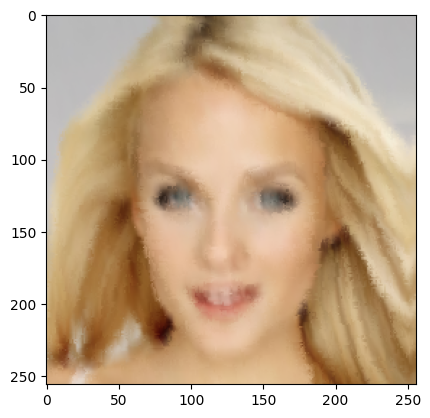

In [8]:
import numpy as np
from scipy import signal
import h5py
import random
from scipy import interpolate
from scipy.stats import norm
import copy
from matplotlib import pyplot as plt
from PIL import Image
import os 

class Turb_Chak():
    def __init__(self,params):
        super().__init__()
        self.params=params
        self.warp_mat =np.zeros((params["Num_D"],2,params["input_size"]+2*params["crop_h"],
                                 params["input_size"]+2*params["crop_w"]))
        self.Num_D = params["Num_D"]
        self.Num_k = params["Num_k"]
        kfp = h5py.File(params["kernel_file"])
        kernels = np.array(kfp['kernels'])
        self.kernels = kernels.transpose([0,2,1])
        self.warp_gen()
        
    def warp_gen(self):
      print("creating warp matrix")
      for i in range(self.Num_D):
        U,V = self.distort_gen(params["input_size"]+2*params["crop_h"],
                                 params["input_size"]+2*params["crop_w"],
                          random.randint(0,4)*3000+1000,
                          self.params["patch_size"],
                          self.params["distortion_strength"])
        self.warp_mat[i,0,:,:] = U
        self.warp_mat[i,1,:,:] = V
#         if (i+1)%int(self.Num_D/3) == 0:
#           print("Still creating")
      print("Done creating warp matrix")
    
    def distort_gen(self, W,H,Num_itr,patch_size,distortion_strength):

        U = np.zeros((W,H))
        V = np.zeros((W,H))
        x_itr = np.linspace(-patch_size-0.5,patch_size+1,2*patch_size+2)
        sigma = 16
        cdf_x = norm.cdf(x_itr,0,sigma)
        # cdf_y = copy.deepcopy(cdf_x)
        pdf_x = cdf_x[1:]-cdf_x[:-1]
        pdf_x = pdf_x/pdf_x.max()
        pdf_x = np.reshape(pdf_x,(2*patch_size+1,1))
        K = np.matmul(pdf_x,pdf_x.transpose())
        for i in range(Num_itr): 
            a = K*random.gauss(0,1)*distortion_strength
            b = K*random.gauss(0,1)*distortion_strength
            x = random.randint(patch_size+1,W-patch_size-2)
            y = random.randint(patch_size+1,H-patch_size-2)
            U[x-patch_size:x+patch_size+1,y-patch_size:y+patch_size+1] += a
            V[x-patch_size:x+patch_size+1,y-patch_size:y+patch_size+1] += b

        return U,V

    def warp(self,I,X_new,Y_new):
        W,H = I.shape
        # print(W,H)
        X_new_1d = np.reshape(X_new,(W*H))
        Y_new_1d = np.reshape(Y_new,(W*H))
        x_f = np.floor(X_new_1d)
        x_f[x_f<0] =0
        x_f[x_f>H-1] = H-1
        y_f = np.floor(Y_new_1d)
        y_f[y_f<0] =0
        y_f[y_f>W-1] = W-1
        x_c = np.ceil(X_new_1d)
        x_c[x_c<0] =0
        x_c[x_c>H-1] = H-1
        y_c = np.ceil(Y_new_1d)
        y_c[y_c<0] =0
        y_c[y_c>W-1] = W-1
        P1 = (X_new_1d-x_f)*(Y_new_1d-y_f)
        P2 = (X_new_1d-x_f)*(Y_new_1d-y_c)
        P3 = (X_new_1d-x_c)*(Y_new_1d-y_f)
        P4 = (X_new_1d-x_c)*(Y_new_1d-y_c)
        # print(x_c.max(),y_c.max())
        A1 = P1* I[y_f.astype(int),x_f.astype(int)]
        A2 = P2* I[y_c.astype(int),x_f.astype(int)]
        A3 = P3* I[y_f.astype(int),x_c.astype(int)]
        A4 = P4* I[y_c.astype(int),x_c.astype(int)]
        I_new = np.reshape(A1-A2-A3+A4,(W,H))

        return I_new


    def simulate(self,img):
        img = np.array(img)/255.0
        img= np.pad(img, ((self.params["crop_h"],self.params["crop_h"]), 
                          (self.params["crop_w"], self.params["crop_w"]),(0,0)),
       mode='symmetric') 
        np.pad(img,(self.params["crop_w"],self.params["crop_w"]))
        img=np.transpose(img,(2,0,1))
        input_img_gt =img                                                                                                                               
        ch,w, h = img.shape
        input_img= np.array(input_img_gt)#.numpy()

        index_blr = random.randint(0,self.Num_k-10)
        input_img[0,:,:]= signal.convolve(input_img[0,:,:],self.kernels[index_blr,:,:],mode='same')
        input_img[1,:,:]= signal.convolve(input_img[1,:,:],self.kernels[index_blr,:,:],mode='same')
        input_img[2,:,:]= signal.convolve(input_img[2,:,:],self.kernels[index_blr,:,:],mode='same')
        index_d = random.randint(0,self.Num_D-1)
        xx,yy = np.meshgrid(np.arange(0,h),np.arange(0,w))
        X_new = xx + self.warp_mat[index_d,0,:,:]
        Y_new = yy + self.warp_mat[index_d,1,:,:]
        input_img1=input_img.copy()
        input_img1[0,:,:] = self.warp(input_img[0,:,:],X_new,Y_new)
        input_img1[1,:,:] = self.warp(input_img[1,:,:],X_new,Y_new)
        input_img1[2,:,:] = self.warp(input_img[2,:,:],X_new,Y_new)
        x,y=self.params["crop_w"],self.params["crop_h"]
        input_img1=input_img1[:,x:x+self.params["input_size"],y:y+self.params["input_size"]]
        input_img1=np.transpose(input_img1,(1,2,0))
        input_img1=np.clip(input_img1,0,1)

        return input_img1


img= Image.open(os.path.join('./test.png'))
params={
    "input_size": 256,
    "crop_h": 21,
    "crop_w": 16,
    "patch_size":6,
    "distortion_strength":0.13,
    "kernel_file": './kernels.mat',
    "Num_D":4000,
    "Num_k":39990
    
}
img=img.resize((params["input_size"],params["input_size"]))
Chak_sim=Turb_Chak(params)
img_chak =Chak_sim.simulate(img)
plt.imshow(img_chak)




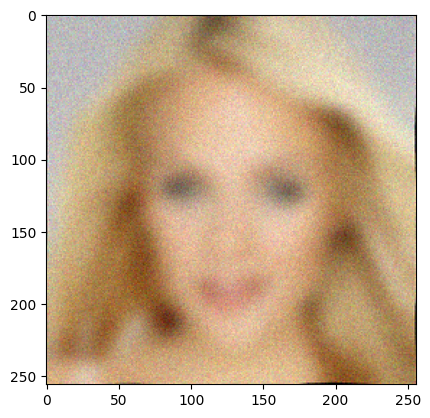

In [5]:
import imgaug.augmenters as iaa
from basicsr.data import degradations as degradations
import math
import cv2
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt

class Turb_Mei():
    def __init__(self,params):
        super().__init__()
        self.params=params
        self.deformation = iaa.ElasticTransformation(alpha=params["alpha"], sigma=params["sigma"]) 

    def simulate(self,img):
        img_lq = np.array(img)/255.0
        kernel = degradations.random_mixed_kernels(
                                ['iso', 'aniso'],
                                self.params["kernel_param_prob"],
                                self.params["blur_kernel_size"] * 2 + 1,
                                self.params["kernel_sigma_x_range"],
                                self.params["kernel_sigma_y_range"],
                                [-math.pi, math.pi],
                                noise_range=None)
        img_lq_blur= cv2.filter2D(img_lq, -1, kernel)
        img_lq_gd = self.deformation(image=img_lq_blur)

        # noise
        img_lq = degradations.random_add_gaussian_noise(img_lq_gd, self.params["gaussian_noise"])

        # round and clip
        img_lq=np.clip(img_lq,0,1)
        
        return img_lq


img= Image.open(os.path.join('./test.png'))
params={
    "alpha": 50,
    "sigma": [10.,20.],
    "gaussian_noise": [0,20],
    "input_size": 256,
    "blur_kernel_size": int(np.random.uniform(15, 25)),
    "kernel_sigma_x_range":[5, 15],
    "kernel_sigma_y_range":[5, 15],
    "kernel_param_prob":[0.5,0.5]
    
}
img=img.resize((params["input_size"],params["input_size"]))
Mei_sim=Turb_Mei(params)
img_mei =Mei_sim.simulate(img)
plt.imshow(img_mei)


